In [2]:
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import freqopttest.glo as glo
import scipy.stats as stats
import sys
from collections import defaultdict
import os
import pandas as pd
import time


def simulate_null_spectral(weights, n_simulate=1000, seed=275):
    """
    weights: chi-square weights (for the infinite weigted sum of chi squares)    
    Return the values of MMD^2 (NOT n*MMD^2) simulated from the null distribution by
    the spectral method.
    """
     # draw at most block_size values at a time
    block_size = 400
    D = chi2_weights.shape[0] #len(weights)
    mmds = np.zeros(n_simulate)
    from_ind = 0

    with util.NumpySeedContext(seed=seed):
        while from_ind < n_simulate:
            to_draw = min(block_size, n_simulate-from_ind)
            # draw chi^2 random variables. 
            chi2 = np.random.randn(D, to_draw)**2
            # an array of length to_draw 
            sim_mmds = 2.0*weights.dot(chi2-1.0)
            # store 
            end_ind = from_ind+to_draw
            mmds[from_ind:end_ind] = sim_mmds
            from_ind = end_ind
    return mmds

def chi_square_weights_H0(k, X):
    """
    Return a numpy array of the weights to be used as the weights in the
    weighted sum of chi-squares for the null distribution of MMD^2.
    - k: a Kernel
    - X: n x d number array of n data points
    """
    n = X.shape[0]
    # Gram matrix
    K = k.eval(X, X)
    # centring matrix. Not the most efficient way.
    H = np.eye(n) - np.ones((n, n))/float(n)
    HKH = H.dot(K).dot(H)
    #https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.eigvals.html
    evals = np.linalg.eigvals(HKH)
    evals = np.real(evals)
    # sort in decreasing order 
    evals = -np.sort(-evals)
    weights = evals/float(n)**2
    return weights


mfdfaDataFrames = '/media/ak/T71/August11th2022Experiments/mfdfaDataFrames'  # Input Files
LinearMMDOutputFiles = '/media/ak/T71/August11th2022Experiments/ExperimentOne/LinearMMDOutputFiles'  # Location to Save Files
symbol = 'JB1'
bar_choice = 'volume'
variable = 'alpha'

file_name = [f for f in os.listdir(mfdfaDataFrames) if str(symbol) and str(variable) in f][0]
file_loc = os.path.join(mfdfaDataFrames, file_name)
unpickled_Df = pd.read_pickle(file_loc)
len = unpickled_Df.shape[1]
print(len)
mmd_train_test_results = defaultdict(dict)
# mmd_test_results_one_dict = defaultdict(dict)
# mmd_test_results_two_dict = defaultdict(dict)
if __name__ == '__main__':
    shift = 2
    window = 10  # slide
    start = time.time()
    for start_point in range(0, (len - window - shift)):
        end_point = start_point + shift

        X = np.array(unpickled_Df.iloc[:, start_point:end_point])
        Y = np.array(unpickled_Df.iloc[:, end_point + shift:end_point + 2 * shift])
        Z = np.array(unpickled_Df.iloc[:, start_point + window:end_point + window])

        tr_data = data.TSTData(X, Y)
        test_data_one = data.TSTData(X, Z)   # data to train the model
        test_data_two =  data.TSTData(Y, Z)
        # training dictionary results 
        tr, te = tr_data.split_tr_te(tr_proportion=0.95, seed=10)  # is this necessary?!
        
        xtr, ytr = tr.xy()
        xytr = tr.stack_xy()
        sig2 = util.meddistance(xytr, subsample=1000)
        k = kernel.KGauss(sig2)
        mean, var = tst.QuadMMDTest.h1_mean_var(xtr, ytr, k, is_var_computed=True)
        Kx = k.eval(xtr, xtr)
        Ky = k.eval(ytr, ytr)
        Kxy = k.eval(xtr, ytr)
        chi2_weights = chi_square_weights_H0(k, xytr)
        mean_gram, var_gram = tst.QuadMMDTest.h1_mean_var_gram(Kx, Ky, Kxy, k, True)
        sim_mmds = simulate_null_spectral(chi2_weights, n_simulate=2000)
        # choose the best parameter and perform a test with permutations
        med = util.meddistance(tr.stack_xy(), 1000)
        list_gwidth = np.hstack( ( (med**2) *(2.0**np.linspace(-4, 4, 20) ) ) )
        list_gwidth.sort()
        list_kernels = [kernel.KGauss(gw2) for gw2 in list_gwidth]

        # grid search to choose the best Gaussian width
        besti, powers = tst.QuadMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.05)
        # perform test 
        best_ker = list_kernels[besti]
        mmd_train_test_results[start_point]['perm_mmds1'] = tst.QuadMMDTest.permutation_list_mmd2(xtr, ytr, k, n_permute=200)
        mmd_train_test_results[start_point]['chi2_weights'] = chi_square_weights_H0(k, xytr)
        mmd_train_test_results[start_point]['sig2'] = sig2
        mmd_train_test_results[start_point]['Kxy'] = k.eval(xtr,ytr)
        mmd_train_test_results[start_point]['mean'] = mean
        mmd_train_test_results[start_point]['var'] = var
        mmd_train_test_results[start_point]['Kxx'] = k.eval(xtr,xtr)
        mmd_train_test_results[start_point]['Kyy'] = k.eval(ytr,ytr)
        mmd_train_test_results[start_point]['mean_gram'] = mean_gram
        mmd_train_test_results[start_point]['var_gram'] = var_gram
        mmd_train_test_results[start_point]['med']=  util.meddistance(tr.stack_xy(), 1000)
        mmd_train_test_results[start_point]['list_gwidth'] = list_gwidth.sort()
        mmd_train_test_results[start_point]['list_kernels'] = list_kernels
        mmd_train_test_results[start_point]['besti'] = besti
        mmd_train_test_results[start_point]['powers'] = powers
        mmd_train_test_results[start_point]['best_ker'] = best_ker
        
        alpha=0.05
        mmd_test = tst.QuadMMDTest(best_ker, n_permute=2000, alpha=alpha)
        mmd_train_test_results[start_point]['XZ_test'] =  mmd_test.perform_test(test_data_one)
        mmd_train_test_results[start_point]['YZ_test'] =  mmd_test.perform_test(test_data_two)
        
        
        
        
        
        #testing the first data set
        
        
        
        

    end = time.time()
    print(end - start)

        
#         a = 0.90
        
#         plt.figure(figsize=(8, 5))
#         plt.hist(perm_mmds1, 20, color='blue', density=True, stacked=True, label='Permutation', alpha=a)
#         plt.hist(sim_mmds, 20, color='lightgreen', density=True, stacked=True, label='Spectral', alpha=a)
#         plt.legend()
#         plt.show()


32
(1/20) KGauss(w2=0.004): mmd2: 0.112, var: 0.00126, power obj: 2.3489, took: 0.00040602684020996094
(2/20) KGauss(w2=0.006): mmd2: 0.122, var: 0.00146, power obj: 2.46858, took: 0.0005440711975097656
(3/20) KGauss(w2=0.007): mmd2: 0.133, var: 0.00167, power obj: 2.57992, took: 0.0004105567932128906
(4/20) KGauss(w2=0.010): mmd2: 0.144, var: 0.0019, power obj: 2.67833, took: 0.0003972053527832031
(5/20) KGauss(w2=0.013): mmd2: 0.154, var: 0.00212, power obj: 2.75892, took: 0.00033855438232421875
(6/20) KGauss(w2=0.018): mmd2: 0.162, var: 0.00229, power obj: 2.81789, took: 0.0003838539123535156
(7/20) KGauss(w2=0.024): mmd2: 0.165, var: 0.00234, power obj: 2.85269, took: 0.0003800392150878906
(8/20) KGauss(w2=0.032): mmd2: 0.163, var: 0.00225, power obj: 2.86014, took: 0.0003685951232910156
(9/20) KGauss(w2=0.043): mmd2: 0.156, var: 0.00201, power obj: 2.83548, took: 0.00037384033203125
(10/20) KGauss(w2=0.057): mmd2: 0.143, var: 0.00168, power obj: 2.77391, took: 0.000381708145141601

(1/20) KGauss(w2=0.001): mmd2: 0.0253, var: 1.02e-05, power obj: 0.796808, took: 0.0003466606140136719
(2/20) KGauss(w2=0.001): mmd2: 0.0278, var: 1.17e-05, power obj: 0.873834, took: 0.0007021427154541016
(3/20) KGauss(w2=0.002): mmd2: 0.0306, var: 1.35e-05, power obj: 0.959674, took: 0.0004878044128417969
(4/20) KGauss(w2=0.002): mmd2: 0.0334, var: 1.54e-05, power obj: 1.04739, took: 0.0003571510314941406
(5/20) KGauss(w2=0.003): mmd2: 0.0359, var: 1.72e-05, power obj: 1.12674, took: 0.00031185150146484375
(6/20) KGauss(w2=0.004): mmd2: 0.0378, var: 1.87e-05, power obj: 1.18552, took: 0.0002894401550292969
(7/20) KGauss(w2=0.006): mmd2: 0.0387, var: 1.94e-05, power obj: 1.21187, took: 0.00032806396484375
(8/20) KGauss(w2=0.008): mmd2: 0.0382, var: 1.9e-05, power obj: 1.19745, took: 0.0003037452697753906
(9/20) KGauss(w2=0.011): mmd2: 0.0364, var: 1.74e-05, power obj: 1.1406, took: 0.00030517578125
(10/20) KGauss(w2=0.014): mmd2: 0.0334, var: 1.48e-05, power obj: 1.04717, took: 0.0003

(1/20) KGauss(w2=0.001): mmd2: 0.0146, var: 6.99e-06, power obj: 0.459728, took: 0.0003216266632080078
(2/20) KGauss(w2=0.001): mmd2: 0.0144, var: 7.29e-06, power obj: 0.452536, took: 0.00035953521728515625
(3/20) KGauss(w2=0.001): mmd2: 0.0139, var: 7.13e-06, power obj: 0.436493, took: 0.0003504753112792969
(4/20) KGauss(w2=0.002): mmd2: 0.0131, var: 6.53e-06, power obj: 0.414387, took: 0.0003352165222167969
(5/20) KGauss(w2=0.002): mmd2: 0.0124, var: 5.61e-06, power obj: 0.390531, took: 0.00032210350036621094
(6/20) KGauss(w2=0.003): mmd2: 0.0117, var: 4.57e-06, power obj: 0.367646, took: 0.0003256797790527344
(7/20) KGauss(w2=0.004): mmd2: 0.0109, var: 3.55e-06, power obj: 0.345012, took: 0.0003216266632080078
(8/20) KGauss(w2=0.006): mmd2: 0.0101, var: 2.66e-06, power obj: 0.31981, took: 0.0003197193145751953
(9/20) KGauss(w2=0.008): mmd2: 0.00919, var: 1.95e-06, power obj: 0.290179, took: 0.0003192424774169922
(10/20) KGauss(w2=0.010): mmd2: 0.00812, var: 1.4e-06, power obj: 0.256

(1/20) KGauss(w2=0.001): mmd2: 0.00943, var: 6.85e-06, power obj: 0.297108, took: 0.0003457069396972656
(2/20) KGauss(w2=0.001): mmd2: 0.0103, var: 7.11e-06, power obj: 0.32492, took: 0.00044536590576171875
(3/20) KGauss(w2=0.001): mmd2: 0.011, var: 6.9e-06, power obj: 0.347527, took: 0.0003619194030761719
(4/20) KGauss(w2=0.002): mmd2: 0.0115, var: 6.26e-06, power obj: 0.363255, took: 0.00034499168395996094
(5/20) KGauss(w2=0.002): mmd2: 0.0117, var: 5.33e-06, power obj: 0.37016, took: 0.0003294944763183594
(6/20) KGauss(w2=0.003): mmd2: 0.0116, var: 4.31e-06, power obj: 0.366437, took: 0.0003256797790527344
(7/20) KGauss(w2=0.004): mmd2: 0.0111, var: 3.33e-06, power obj: 0.351171, took: 0.0003204345703125
(8/20) KGauss(w2=0.006): mmd2: 0.0103, var: 2.49e-06, power obj: 0.325087, took: 0.0003294944763183594
(9/20) KGauss(w2=0.007): mmd2: 0.0092, var: 1.8e-06, power obj: 0.290818, took: 0.00032258033752441406
(10/20) KGauss(w2=0.010): mmd2: 0.00798, var: 1.27e-06, power obj: 0.252216, 

(1/20) KGauss(w2=0.001): mmd2: 0.0232, var: 9.3e-06, power obj: 0.729026, took: 0.00032973289489746094
(2/20) KGauss(w2=0.001): mmd2: 0.0261, var: 1.12e-05, power obj: 0.821006, took: 0.0004680156707763672
(3/20) KGauss(w2=0.002): mmd2: 0.0293, var: 1.33e-05, power obj: 0.91954, took: 0.000362396240234375
(4/20) KGauss(w2=0.002): mmd2: 0.0323, var: 1.55e-05, power obj: 1.01434, took: 0.00032711029052734375
(5/20) KGauss(w2=0.003): mmd2: 0.0348, var: 1.73e-05, power obj: 1.09162, took: 0.00032258033752441406
(6/20) KGauss(w2=0.004): mmd2: 0.0363, var: 1.84e-05, power obj: 1.13706, took: 0.00032138824462890625
(7/20) KGauss(w2=0.005): mmd2: 0.0364, var: 1.84e-05, power obj: 1.14015, took: 0.0003218650817871094
(8/20) KGauss(w2=0.007): mmd2: 0.035, var: 1.71e-05, power obj: 1.09798, took: 0.0003209114074707031
(9/20) KGauss(w2=0.010): mmd2: 0.0324, var: 1.47e-05, power obj: 1.01626, took: 0.00033926963806152344
(10/20) KGauss(w2=0.013): mmd2: 0.0288, var: 1.18e-05, power obj: 0.906693, to

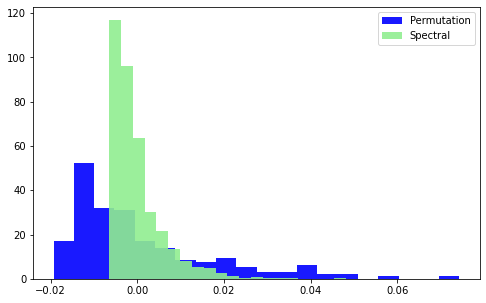

In [67]:
xytr = test_data_one.stack_xy()
chi2_weights = chi_square_weights_H0(k, xytr)
sim_mmds = simulate_null_spectral(chi2_weights, n_simulate=2000)
a = 0.90

plt.figure(figsize=(8, 5))
plt.hist(perm_mmds1,20, color='blue', density=True,stacked=True, label='Permutation', alpha=a)
plt.hist(sim_mmds, 20, color='lightgreen', density=True,stacked=True, label='Spectral', alpha=a)
plt.legend()

In [44]:
# test h1_mean_var
start = time.time()
mean, var = tst.QuadMMDTest.h1_mean_var(xtr, ytr, k, is_var_computed=True)
end = time.time()
print('h1_mean_var took: %.3f'%(end - start))
print('mean: %.3g, var: %.3g'%(mean, var))

h1_mean_var took: 0.003
mean: 0.0301, var: 3.17e-06


In [45]:
#test h1_mean_var_gram
start = time.time()
Kx = k.eval(xtr, xtr)
Ky = k.eval(ytr, ytr)
Kxy = k.eval(xtr, ytr)
mean, var = tst.QuadMMDTest.h1_mean_var_gram(Kx, Ky, Kxy, k, True)
end = time.time()
print('h1_mean_var took: %.3f'%(end - start))
print('mean: %.3g, var: %.3g'%(mean, var))

h1_mean_var took: 0.002
mean: 0.0301, var: 3.17e-06


In [46]:
# choose the best parameter and perform a test with permutations
med = util.meddistance(tr.stack_xy(), 1000)
list_gwidth = np.hstack( ( (med**2) *(2.0**np.linspace(-4, 4, 20) ) ) )
list_gwidth.sort()
list_kernels = [kernel.KGauss(gw2) for gw2 in list_gwidth]

# grid search to choose the best Gaussian width
besti, powers = tst.QuadMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.6)
# perform test 
best_ker = list_kernels[besti]

(1/20) KGauss(w2=0.053): mmd2: 0.144, var: 0.000657, power obj: 3.54931, took: 0.0004754066467285156
(2/20) KGauss(w2=0.072): mmd2: 0.133, var: 0.000558, power obj: 3.37829, took: 0.0005431175231933594
(3/20) KGauss(w2=0.096): mmd2: 0.121, var: 0.000435, power obj: 3.18441, took: 0.0004553794860839844
(4/20) KGauss(w2=0.128): mmd2: 0.107, var: 0.0003, power obj: 2.96527, took: 0.0004487037658691406
(5/20) KGauss(w2=0.172): mmd2: 0.0928, var: 0.000163, power obj: 2.72315, took: 0.0004620552062988281
(6/20) KGauss(w2=0.230): mmd2: 0.0791, var: 2.85e-05, power obj: 2.46721, took: 0.00048089027404785156
(7/20) KGauss(w2=0.308): mmd2: 0.0663, var: 1.8e-05, power obj: 2.07766, took: 0.0005135536193847656
(8/20) KGauss(w2=0.412): mmd2: 0.0547, var: 1.16e-05, power obj: 1.72032, took: 0.0004467964172363281
(9/20) KGauss(w2=0.552): mmd2: 0.0446, var: 7.38e-06, power obj: 1.40422, took: 0.00044536590576171875
(10/20) KGauss(w2=0.739): mmd2: 0.0359, var: 4.61e-06, power obj: 1.13113, took: 0.0004

In [70]:
start = time.time()
alpha=0.05
mmd_test = tst.QuadMMDTest(best_ker, n_permute=200, alpha=alpha)
test_result = mmd_test.perform_test(test_data_one)
end = time.time()
print('MMD test took: %s seconds'%(end-start))
test_result

MMD test took: 0.03632354736328125 seconds


{'alpha': 0.05,
 'pvalue': 0.0,
 'test_stat': 0.26701102558457945,
 'h0_rejected': True,
 'list_permuted_mmd2': array([ 7.12351157e-03, -9.58645099e-03, -9.78246401e-03,  7.87747948e-03,
         3.42165391e-02,  1.72632470e-02, -1.49110198e-02,  1.25672008e-02,
        -6.89223645e-03, -9.17920912e-03, -1.45754797e-03,  7.61791613e-03,
        -1.55868706e-02,  3.50300373e-03,  1.01485404e-02, -1.28645614e-02,
        -1.46143844e-02,  1.28251348e-02,  3.67426449e-03, -9.19862675e-04,
         1.63251284e-02, -1.37686627e-02, -4.09810591e-03, -1.29159876e-02,
        -7.51182099e-03, -3.19917286e-03,  1.01815323e-02,  3.94090555e-03,
         1.24114261e-02, -1.32748565e-02,  9.37907362e-03, -5.67679982e-03,
        -1.31696056e-02, -6.47314031e-03, -2.70287334e-03, -1.31479825e-02,
        -3.70757312e-03, -4.58764942e-03, -3.24605123e-03, -7.88547589e-03,
        -1.34968051e-02, -1.17541794e-02, -5.32225875e-03, -8.27855941e-03,
        -6.46557827e-03, -7.28730740e-03,  2.44360101

med^2: 0.855
best width^2: 0.053


Text(0, 0.5, 'Approx. test power')

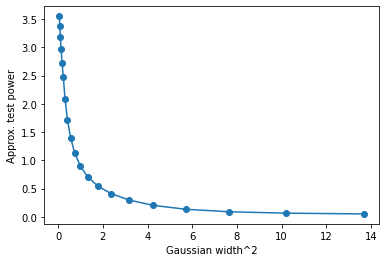

In [71]:
print ('med^2: %.3f'%med**2)
print ('best width^2: %.3f'%(list_gwidth[besti]))
plt.plot(list_gwidth, powers, 'o-')
plt.xlabel('Gaussian width^2')
plt.ylabel('Approx. test power')

/home/ak/anaconda3/envs/kernels/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


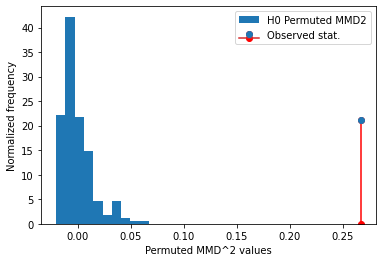

In [72]:
permuted_mmd2s = test_result['list_permuted_mmd2']
stat = test_result['test_stat']
bins = plt.hist(permuted_mmd2s, 10, density=True,stacked=True, label='H0 Permuted MMD2');
plt.xlabel('Permuted MMD^2 values')
plt.ylabel('Normalized frequency')
plt.stem([stat], [max(bins[0])/2], 'or-', label='Observed stat.')
plt.legend()


In [87]:
test_result.keys()

dict_keys(['alpha', 'pvalue', 'test_stat', 'h0_rejected', 'list_permuted_mmd2'])

In [73]:
start = time.time()
alpha=0.05
mmd_test = tst.QuadMMDTest(best_ker, n_permute=1000, alpha=alpha)
test_result = mmd_test.perform_test(test_data_two)
end = time.time()
print('MMD test took: %s seconds'%(end-start))
test_result

MMD test took: 0.14921021461486816 seconds


{'alpha': 0.05,
 'pvalue': 0.0,
 'test_stat': 0.3567640284871808,
 'h0_rejected': True,
 'list_permuted_mmd2': array([ 1.95212903e-02, -1.05275025e-02, -7.13513128e-03,  1.59701243e-02,
         2.74977660e-02,  1.22307215e-02, -1.12731769e-02,  4.11423763e-03,
        -5.54760300e-03, -6.48133055e-03, -9.30733315e-04,  2.64441796e-03,
        -1.44485439e-02,  5.43482947e-03,  4.23900294e-03, -9.07549522e-03,
        -1.28255387e-02,  1.43102750e-02, -1.70738190e-03, -2.67882052e-04,
         1.07251452e-02, -1.34401298e-02,  5.21928729e-03, -3.32128048e-03,
        -7.98202188e-03,  2.72283026e-03,  7.65050014e-04,  8.68938776e-03,
         2.50883574e-03, -1.44956901e-02,  8.71586829e-03, -1.10236990e-02,
        -9.73449914e-03, -1.84595509e-03, -3.03464644e-04, -8.15438413e-03,
        -6.99240069e-04, -6.40290967e-03, -3.17342787e-03,  2.14084727e-03,
        -8.64845701e-03, -8.06514920e-03, -1.10511270e-02, -1.06182846e-02,
        -6.26804592e-03,  4.09671951e-04,  2.12006639e

med^2: 0.855
best width^2: 0.053


Text(0, 0.5, 'Approx. test power')

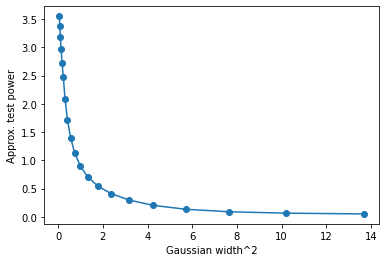

In [53]:
print ('med^2: %.3f'%med**2)
print ('best width^2: %.3f'%(list_gwidth[besti]))
plt.plot(list_gwidth, powers, 'o-')
plt.xlabel('Gaussian width^2')
plt.ylabel('Approx. test power')

/home/ak/anaconda3/envs/kernels/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


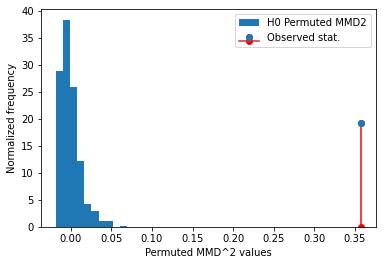

In [54]:
permuted_mmd2s = test_result['list_permuted_mmd2']
stat = test_result['test_stat']
bins = plt.hist(permuted_mmd2s, 10, density=True,stacked=True, label='H0 Permuted MMD2');
plt.xlabel('Permuted MMD^2 values')
plt.ylabel('Normalized frequency')
plt.stem([stat], [max(bins[0])/2], 'or-', label='Observed stat.')
plt.legend()


In [3]:
location = '/media/ak/T71/August11th2022Experiments/ExperimentOne/LinearMMDOutputFiles'

In [5]:
files = os.listdir(location)
quad_mmd = [f for f in files if str('_quad_') in f]

In [14]:
idx_file = quad_mmd[2]
idx_file_loc = os.path.join(location, idx_file)
idx_file_loc

'/media/ak/T71/August11th2022Experiments/ExperimentOne/LinearMMDOutputFiles/JB1_tau_shift_2_wind_5_quad_MMD_test.pkl'

In [15]:
pd.read_pickle(idx_file_loc)

defaultdict(dict,
            {0: {'perm_mmds1': array([-0.00695691, -0.00094928, -0.00843021, ...,  0.00079901,
                     -0.00271997, -0.00899369]),
              'chi2_weights': array([ 1.85899781e-03,  5.72154703e-04,  2.11040513e-04,  1.25367978e-04,
                      5.80859522e-05,  3.14847591e-05,  1.34200047e-05,  6.70251644e-06,
                      3.68622850e-06,  1.41413995e-06,  8.23234964e-07,  2.67266276e-07,
                      1.81592523e-07,  5.29332338e-08,  3.67708796e-08,  9.31151961e-09,
                      5.57594677e-09,  1.50058095e-09,  7.89546027e-10,  2.64903775e-10,
                      1.12621454e-10,  3.56935837e-11,  1.79788214e-11,  6.00526764e-12,
                      3.61286907e-12,  1.95356776e-12,  4.12385399e-13,  2.91515133e-13,
                      5.63592125e-14,  3.04941351e-14,  8.11866926e-15,  3.03862482e-15,
                      1.05866456e-15,  4.27448447e-16,  1.44394818e-16,  7.52044499e-17,
                     